# Keras net surgery example

### Convolution network can be translated to fully convolution network by replace fully connected layers with convolutional layers. For example we take CNN from donkeycar project https://github.com/wroscoe/donkey. This network predict the steering angle and throttle of small scale autonomous vehicle.

### Why do we want to make this translation? At least three things:
### 1) FCN networks is independent of size of input.
### 2) If we will use input with higher resolution than original input, we will get network predictions in few spatial locations of input, which we can avarage and obtain better predictions.
### 3) Fully convolutional network can be finetuned for image segmentation.

In [1]:
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
import numpy as np

Using TensorFlow backend.


In [2]:
def default_categorical():
    img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu', name = 'conv1')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu', name = 'conv2')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu', name = 'conv3')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu', name = 'conv4')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu', name = 'conv5')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(100, activation='relu', name = 'dense1')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='relu', name = 'dense2')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    #categorical output of the angle
    angle_out = Dense(15, activation='softmax', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
    
    #continous output of throttle
    throttle_out = Dense(1, activation='relu', name='throttle_out')(x)      # Reduce to 1 number, Positive number only
    
    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])
  
    return model

#### This network take the input images with shape (120, 160, 3) and output the distribution over 15 possible steering angles of vehicle and throttle.

#### Now let's load the pretrained model weights and print network structure.

In [3]:
model = default_categorical()

In [4]:
model.load_weights('weights.h5')

In [5]:
model.get_config()

{'input_layers': [['img_in', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 120, 160, 3),
    'dtype': 'float32',
    'name': 'img_in',
    'sparse': False},
   'inbound_nodes': [],
   'name': 'img_in'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'filters': 24,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': 'uniform',
      'mode': 'fan_avg',
      'scale': 1.0,
      'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (5, 5),
    'name': 'conv1',
    'padding': 'valid',
    'strides': (2, 2),
    'trainable': True,
    'use_bias': True},
   'inbound_nodes': [[['img_in', 0, 0, {}]]],
   'name': 'conv1'},
  {'clas

### Now let's construct FCNN equiualent

In [6]:
img_in = Input(shape=(None, None, 3), name='img_in')
x = img_in
x = Convolution2D(24, (5,5), strides=(2,2), activation='relu', name = 'fcn_conv1')(x)
x = Convolution2D(32, (5,5), strides=(2,2), activation='relu', name = 'fcn_conv2')(x)
x = Convolution2D(64, (5,5), strides=(2,2), activation='relu', name = 'fcn_conv3')(x)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu', name = 'fcn_conv4')(x)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu', name = 'fcn_conv5')(x)

#### To replace first FC layer with convolution layer we just need to compute the filter shape and number of filters so that output shape of new conv layer be equal to output of FC layer

#### Input of 'dense1' layer has input shape

In [7]:
model.get_layer(name='flattened').compute_output_shape((1, 3, 6, 64))

(1, 1152)

#### output of 'dense1' layer has shape

In [8]:
model.get_layer(name='dense1').compute_output_shape((1, 1152))

(1, 100)

#### In our new model we remove 'flattened' layer so the input of our new conv layer 'fcn_conv6' has shape of layer 'conv5' output  = (1, 3, 6, 64). And we already know that output of 'fcn_conv6' must be equal of output 'dense1' layer. So we can compute the shape of convolution filters.

In [9]:
x = Convolution2D(100, (3,6), strides=1, activation='relu', name = 'fcn_conv6')(x)

#### Similarly we can compute filters shape of remaining layers

In [10]:
x = Convolution2D(50, (1,1), strides=1, activation='relu', name = 'fcn_conv7')(x)
angle_out = Convolution2D(15, (1,1), strides=1, activation='softmax', name='angle_out')(x)
throttle_out = Convolution2D(1,  (1,1), strides=1, activation='relu', name='throttle_out')(x)

In [11]:
fcn_model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])

### Now let's set weights to new FCNN model

#### At first we simply set weights to top 5 conv layers because this weights don't need to be reshaped

In [12]:
for i in range(1, 6):
    fcn_model.get_layer('fcn_conv%s'%i).set_weights(model.get_layer('conv%s'%i).get_weights())

#### Next we need to set weights to 'fcn_conv6' which replaced 'dense1' layer from original network.

#### To do that we need to reshape weights of 'dense1' layer to shape of weight of folters of 'fcn_conv6'

In [13]:
dense_1_weights = model.get_layer('dense1').get_weights()
print('Shape of dense1: %s' % str(dense_1_weights[0].shape))
print('Shape of fcn_conv7: %s' % str((3, 6, 64, 100)))

Shape of dense1: (1152, 100)
Shape of fcn_conv7: (3, 6, 64, 100)


#### Just reshape weights and set to 'fcn_conv6' layer

In [14]:
fcn_conv6_weights = np.reshape(dense_1_weights[0], (3, 6, 64, 100))
fcn_model.get_layer('fcn_conv6').set_weights([fcn_conv6_weights, dense_1_weights[1]])

#### Similarily set weights to remaining layers

In [15]:
dense_2_weights = model.get_layer('dense2').get_weights()
fcn_model.get_layer('fcn_conv7').set_weights([np.reshape(dense_2_weights[0], (1, 1, 100, 50)), dense_2_weights[1]])

angle_out_weights = model.get_layer('angle_out').get_weights()
fcn_model.get_layer('angle_out').set_weights([np.reshape(angle_out_weights[0], (1, 1, 50, 15)), angle_out_weights[1]])

throttle_out_weights = model.get_layer('throttle_out').get_weights()
fcn_model.get_layer('throttle_out').set_weights([np.reshape(throttle_out_weights[0], (1, 1, 50, 1)), throttle_out_weights[1]])

### Now lets test the result

In [16]:
def linear_unbin(arr):
    b = np.argmax(arr)
    a = b *(2/14) - 1
    return a

In [17]:
import cv2
test_img = cv2.imread('imgs/1_cam-image_array_.jpg')

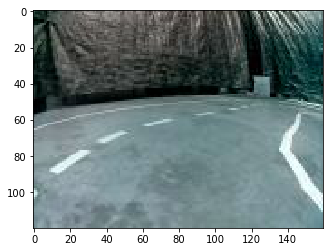

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(test_img)

#### Model prediction comparision

In [19]:
original_prediction = model.predict(np.array([test_img]))
fcn_prediction = fcn_model.predict(np.array([test_img]))

In [21]:
print('Prediction of original model: angle = %f, throttle = %f' % \
      (linear_unbin(original_prediction[0]), original_prediction[1]))
print('Prediction of FCN model: angle = %f, throttle = %f' % \
      (linear_unbin(fcn_prediction[0]), fcn_prediction[1]))

Prediction of original model: angle = -0.571429, throttle = 0.302568
Prediction of FCN model: angle = -0.571429, throttle = 0.302568


## As expected outputs are identical!